In [2]:
import pandas as pd
import re
from collections import Counter
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

In [3]:
# Read the list of filenames from the configuration file
with open('../file_list.txt', 'r', encoding='utf-8') as config_file:
    file_names = config_file.read().splitlines()

# Regex pattern to match the data format
pattern = r'\[(.*?)\] (.*?): (.*)'

# Initialize an empty list to store parsed data
datalist = []
stream_count = 0
# Iterate over each specified file
for file in file_names:
    full_path = f"../data/{file}"
    with open(full_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            match = re.match(pattern, line)
            if match:
                date, user, message = match.groups()
                datalist.append([date, user, message,stream_count])
    stream_count = stream_count + 1

# Create a DataFrame from the parsed data
data = pd.DataFrame(datalist, columns=["date", "user", "message","stream"])
data['date'] = pd.to_datetime(data['date'])

# Create a DataFrame from the parsed data
data = pd.DataFrame(datalist, columns=["date", "user", "message","stream"])

data["user"] = data["user"].replace("Banties1g", "banties_x")
data["user"] = data["user"].replace("banties1g", "banties_x")
data["user"] = data["user"].replace("fyodor_m_d1821", "fyredoor4")
data["user"] = data["user"].replace("chili_poe", "chili_con_bacon")


In [4]:
# Find the first stream where each user sent a message
first_stream_df = data.groupby("user")["stream"].min().reset_index()
first_stream_df.rename(columns={"stream": "first_stream"}, inplace=True)

In [5]:
# Merge with the original DataFrame
data = data.merge(first_stream_df, on="user", how="left")
data.tail(10)

,date,user,message,stream,first_stream
1364406,2025-03-19 23:00:07 UTC,trek44_,WW stream,269,265
1364407,2025-03-19 23:00:07 UTC,Adevogado__33,bye,269,267
1364408,2025-03-19 23:00:08 UTC,gumubo44,take care,269,259
1364409,2025-03-19 23:00:08 UTC,banties_x,bye,269,0
1364410,2025-03-19 23:00:08 UTC,kirill_ugrumov,dorozeaHey,269,175
1364411,2025-03-19 23:00:08 UTC,fouloutsosa300,bb,269,269
1364412,2025-03-19 23:00:08 UTC,JBIN2036,bye,269,120
1364413,2025-03-19 23:00:09 UTC,gumubo44,you too,269,259
1364414,2025-03-19 23:00:09 UTC,ACEiCLE,bye @dorozea 󠀀,269,228
1364415,2025-03-19 23:00:10 UTC,trek44_,keep it smurf chat,269,265


In [6]:
# Count occurrences of first_stream for each stream
pivot_table = data.groupby(["stream", "first_stream"]).size().unstack(fill_value=0)

# Reset index for better readability
pivot_table = pivot_table.reset_index()

In [7]:
pivot_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Columns: 271 entries, stream to 269
dtypes: int64(271)
memory usage: 571.8 KB


In [8]:
pivot_table = pivot_table.drop(columns=['stream'])

In [9]:
pivot_table

first_stream,0,1,2,3,4,5,6,7,8,9,...,260,261,262,263,264,265,266,267,268,269
0,1985,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2105,941,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2150,204,400,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1788,87,103,397,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1842,87,102,80,344,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,3020,175,221,4,0,467,7,278,1,44,...,396,289,156,115,100,3382,0,0,0,0
266,556,28,7,2,0,39,19,34,0,38,...,58,39,22,101,65,58,316,0,0,0
267,711,107,28,0,0,19,1,19,0,63,...,553,45,79,140,158,716,54,1152,0,0
268,1265,85,83,0,1,90,39,1,0,48,...,432,214,25,178,132,318,96,167,1445,0


In [10]:
# Convert 'date' to datetime format and extract the month for color mapping
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month

# Get the month for each stream
stream_months = data.groupby('stream')['month'].first()

# Get the month for each stream
stream_months = data.groupby("stream")["month"].first()

# Define base colors for each month
base_color_map = {
    1: '#008B8B',  # Dark Cyan
    2: '#FF8C00',  # Dark Orange
    3: '#006400',  # Dark Green
    4: '#8B0000',  # Dark Red
    5: '#450145',  # Dark Purple
    6: '#00008B',  # Dark Blue
    7: '#808000',  # Olive
    8: '#006400',  # Dark Green
    9: '#8B4513',  # SaddleBrown
    10: '#a10202',  # Deep Red
    11: '#242323',  # Dark Gray
    12: '#730049'  # Dark Magenta
}

# Function to generate shades for each month color
def generate_shades(base_color, n_shades, lightness_factor=0.7):
    color = mcolors.to_rgba(base_color)
    light_color = [1 - (1 - c) * (1 - lightness_factor) for c in color]  # Generate a lighter color
    cmap = mcolors.LinearSegmentedColormap.from_list(
        f'shades_of_{base_color}', [color, light_color], N=n_shades)
    return [cmap(i) for i in range(n_shades)]

# Create a color mapping for each stream based on the month
color_list = []
for month in stream_months.unique():
    month_streams = stream_months[stream_months == month].index
    n_streams_in_month = len(month_streams)
    base_color = base_color_map.get(month, "#808080")  # Default gray if month is missing

    # Generate shades
    shades = generate_shades(base_color, n_streams_in_month) if n_streams_in_month > 1 else [base_color]

    # Assign shades to streams
    for i, stream in enumerate(month_streams):
        color_list.append((stream, shades[i]))

# Convert to dictionary for easy lookup
color_dict = dict(color_list)

# Ensure colors match pivot table index
sorted_color_list = [color_dict[stream] for stream in pivot_table.index]

In [11]:
sorted_color_list

[(0.27058823529411763, 0.00392156862745098, 0.27058823529411763, 1.0),
 (0.2888235294117647, 0.028823529411764706, 0.2888235294117647, 1.0),
 (0.3070588235294117, 0.05372549019607843, 0.3070588235294117, 1.0),
 (0.3252941176470588, 0.07862745098039216, 0.3252941176470588, 1.0),
 (0.34352941176470586, 0.10352941176470588, 0.34352941176470586, 1.0),
 (0.3617647058823529, 0.1284313725490196, 0.3617647058823529, 1.0),
 (0.37999999999999995, 0.15333333333333332, 0.37999999999999995, 1.0),
 (0.398235294117647, 0.17823529411764705, 0.398235294117647, 1.0),
 (0.41647058823529404, 0.20313725490196077, 0.41647058823529404, 1.0),
 (0.43470588235294116, 0.22803921568627455, 0.43470588235294116, 1.0),
 (0.4529411764705882, 0.2529411764705882, 0.4529411764705882, 1.0),
 (0.47117647058823525, 0.27784313725490195, 0.47117647058823525, 1.0),
 (0.4894117647058823, 0.3027450980392157, 0.4894117647058823, 1.0),
 (0.5076470588235293, 0.3276470588235294, 0.5076470588235293, 1.0),
 (0.5258823529411765, 0.352

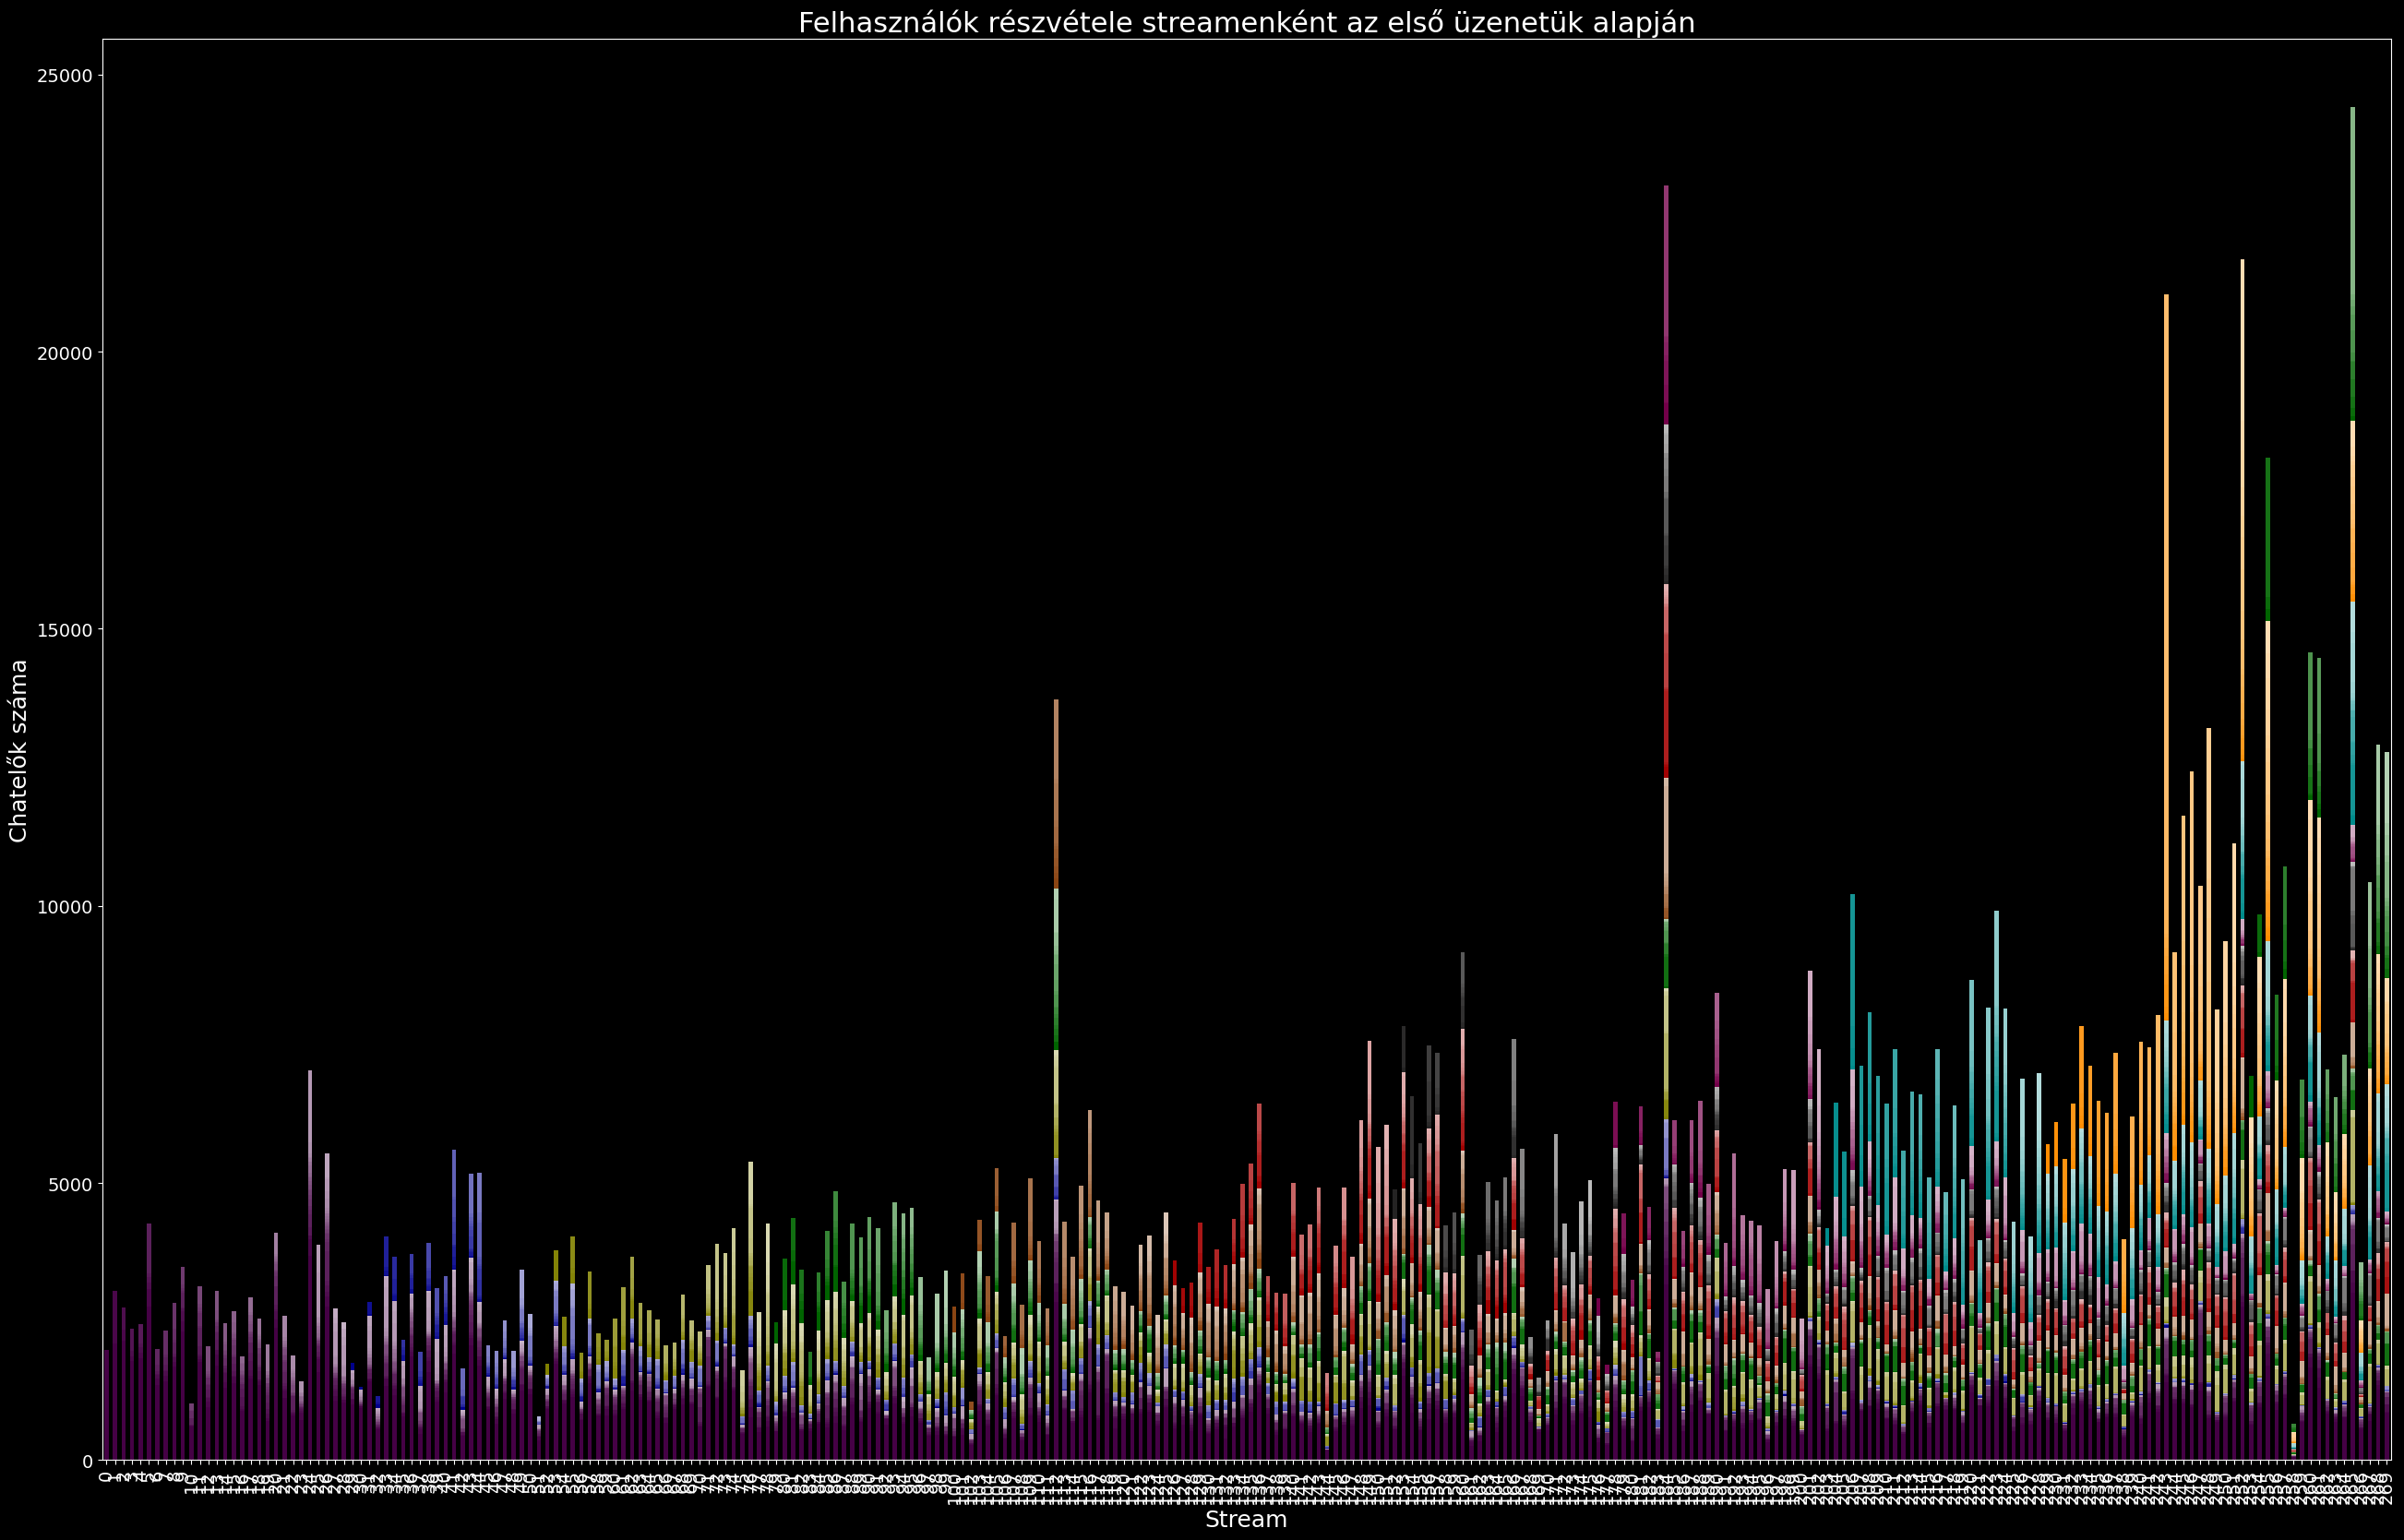

In [12]:
# Plot stacked bar chart
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(32, 20))

pivot_table.plot(kind='bar', stacked=True, ax=ax, color=sorted_color_list, legend=False)

plt.title('Felhasználók részvétele streamenként az első üzenetük alapján', fontsize=22)
plt.xlabel('Stream', fontsize=18)
plt.ylabel('Chatelők száma', fontsize=18)

plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)

plt.show()

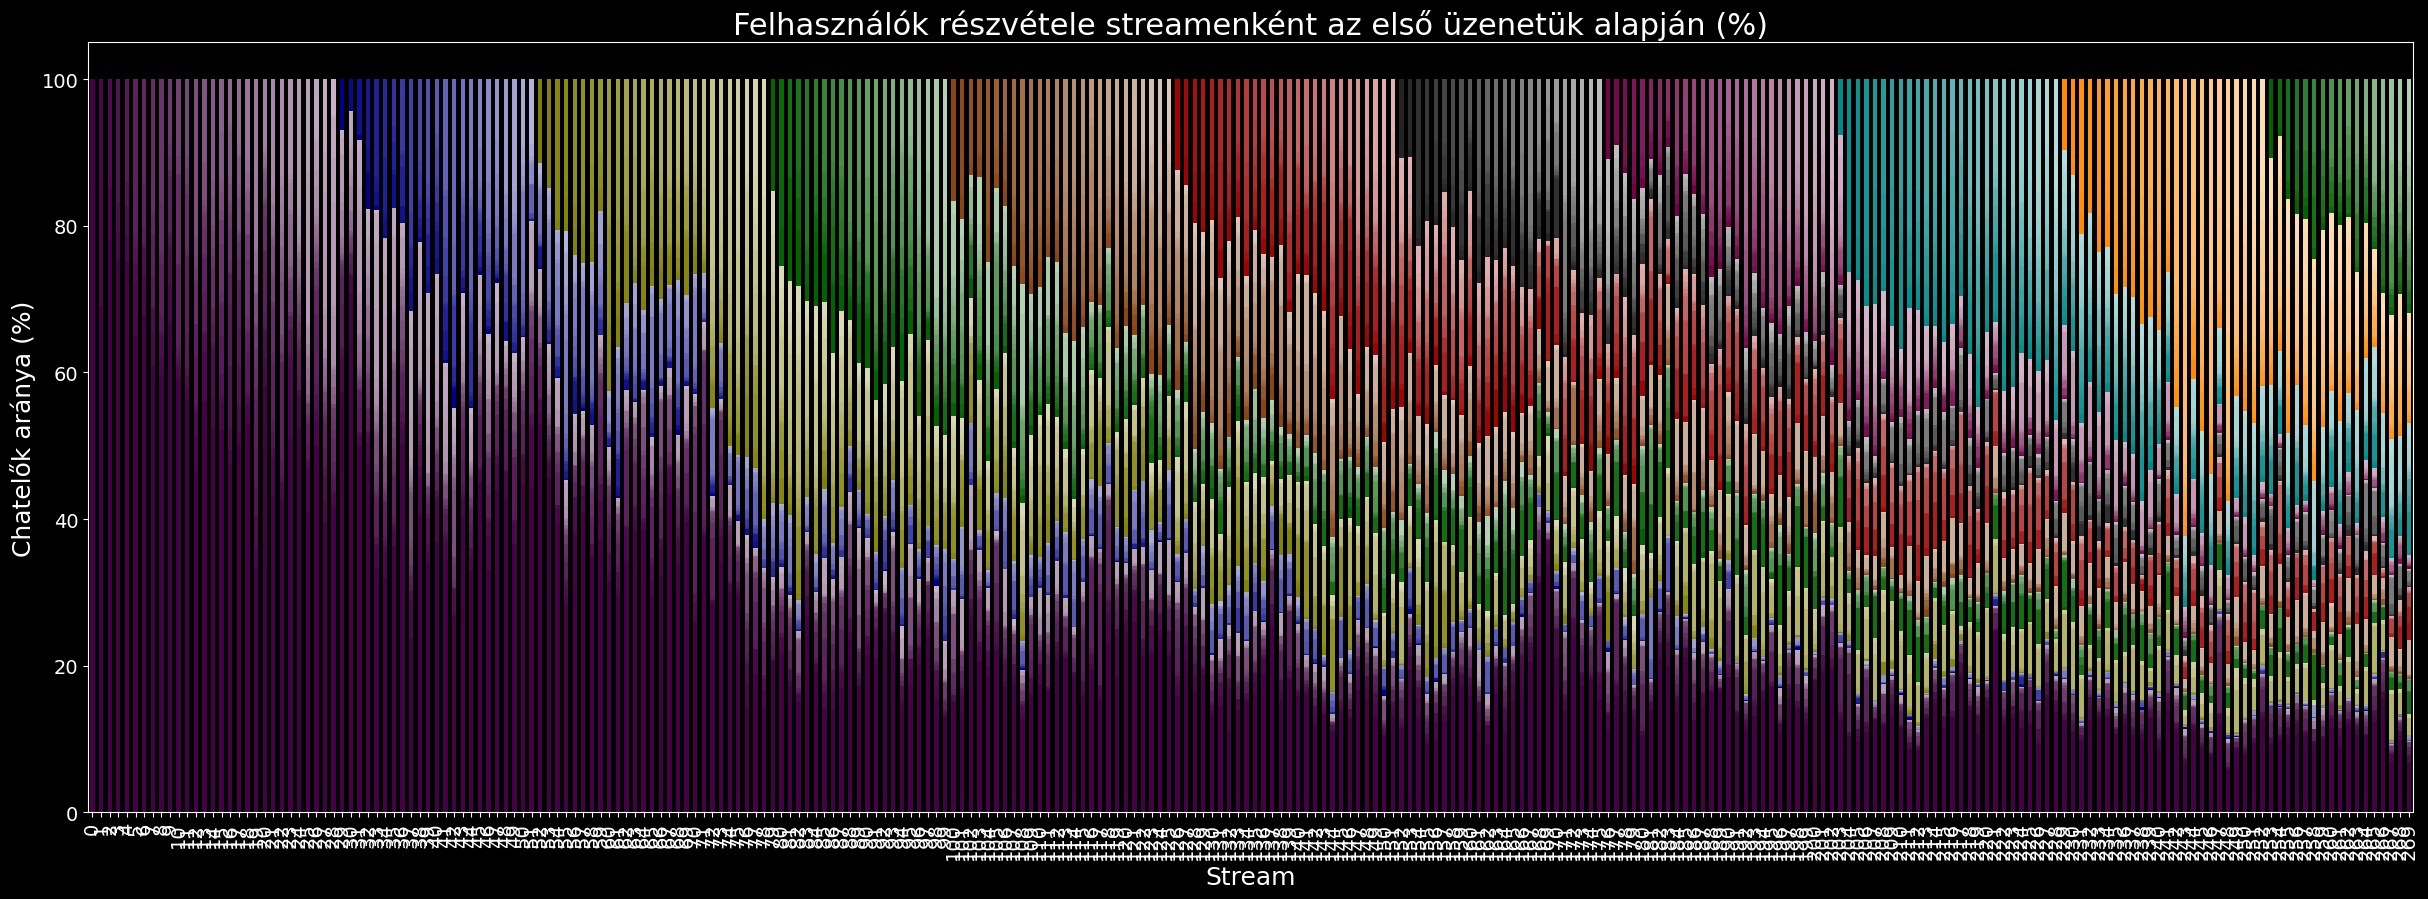

In [13]:
# Convert pivot table values to percentages (row-wise normalization)
pivot_table_percentage = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

# Plot the percentage-based stacked bar chart
fig, ax = plt.subplots(figsize=(30, 10))

pivot_table_percentage.plot(kind='bar', stacked=True, ax=ax, color=sorted_color_list, legend=False)

plt.title('Felhasználók részvétele streamenként az első üzenetük alapján (%)', fontsize=22)
plt.xlabel('Stream', fontsize=18)
plt.ylabel('Chatelők aránya (%)', fontsize=18)

plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)

plt.show()

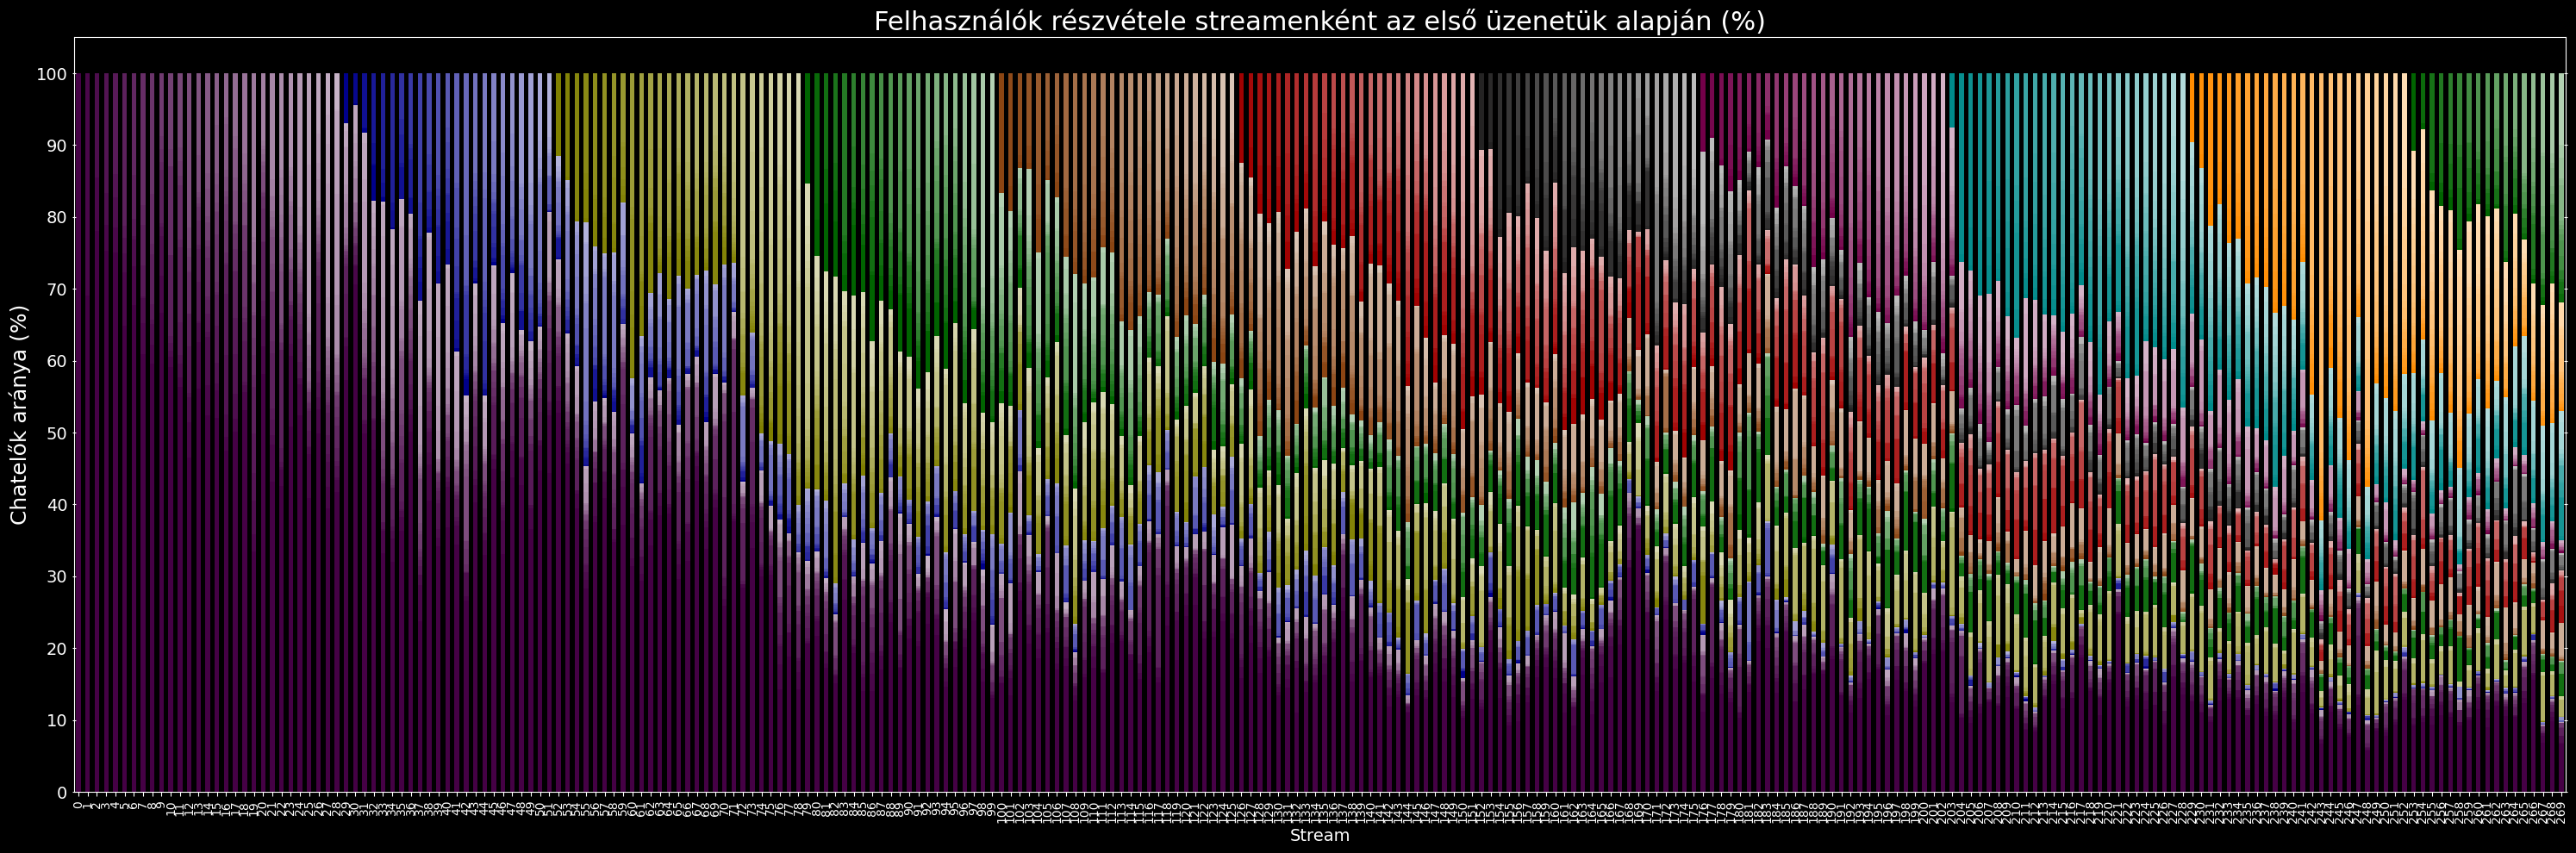

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Create the figure and axis
fig, ax = plt.subplots(figsize=(30, 10))

# Plot the stacked bar chart
pivot_table_percentage.plot(kind='bar', stacked=True, ax=ax, color=sorted_color_list, legend=False)

# Title and labels
plt.title('Felhasználók részvétele streamenként az első üzenetük alapján (%)', fontsize=22)
plt.xlabel('Stream', fontsize=14)  # Smaller font for x-label
plt.ylabel('Chatelők aránya (%)', fontsize=18)

# Adjust x-ticks and y-ticks
plt.xticks(rotation=90, fontsize=10)  # Even smaller x-axis labels
plt.yticks(np.arange(0, 101, 10), fontsize=14)  # Y-axis ticks every 10

# Show y-ticks on both sides
ax.yaxis.set_ticks_position('both')
ax.yaxis.set_tick_params(which='both', direction='inout')

plt.tight_layout()
plt.show()

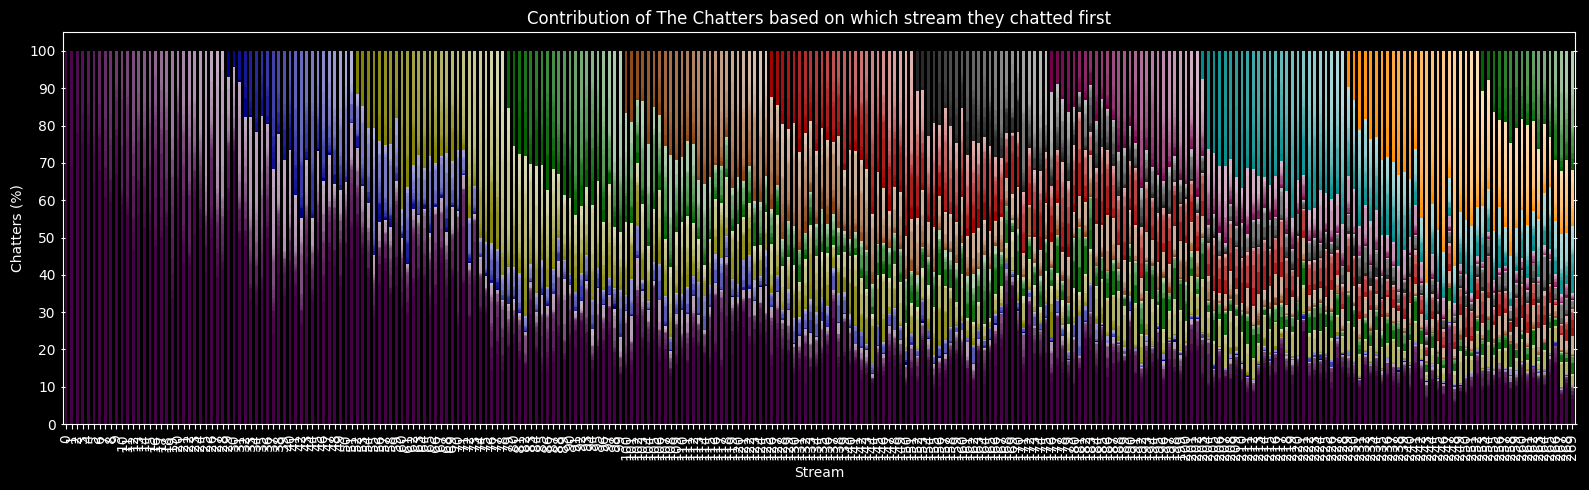

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the percentage data
plt.style.use('dark_background')
ax = pivot_table_percentage.plot(kind='bar', stacked=True, figsize=(16, 5), color=sorted_color_list, legend=False)

plt.title('Contribution of The Chatters based on which stream they chatted first')

# Adjust x and y labels
plt.xlabel('Stream', fontsize=10)  # Make x-axis label smaller
plt.ylabel('Chatters (%)')

# Adjust y-axis ticks to show every 10
plt.yticks(np.arange(0, 101, 10))  

# Show y-axis ticks on both left and right
ax.yaxis.set_ticks_position('both')  
ax.tick_params(axis='y', direction='inout')

plt.tight_layout()
plt.show()

In [16]:
pivot_table_percentage

first_stream,0,1,2,3,4,5,6,7,8,9,...,260,261,262,263,264,265,266,267,268,269
0,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,69.107026,30.892974,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,78.068264,7.407407,14.524328,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,75.284211,3.663158,4.336842,16.715789,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,75.030550,3.543788,4.154786,3.258656,14.012220,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,12.366912,0.716626,0.904996,0.016380,0.000000,1.912367,0.028665,1.138411,0.004095,0.180180,...,1.621622,1.183456,0.638821,0.470925,0.409500,13.849304,0.000000,0.000000,0.000000,0.000000
266,15.569868,0.784094,0.196024,0.056007,0.000000,1.092131,0.532064,0.952114,0.000000,1.064128,...,1.624195,1.092131,0.616074,2.828339,1.820218,1.624195,8.849062,0.000000,0.000000,0.000000
267,6.815567,1.025690,0.268405,0.000000,0.000000,0.182132,0.009586,0.182132,0.000000,0.603911,...,5.300997,0.431365,0.757285,1.342025,1.514571,6.863497,0.517638,11.042945,0.000000,0.000000
268,9.802402,0.658659,0.643162,0.000000,0.007749,0.697404,0.302208,0.007749,0.000000,0.371949,...,3.347540,1.658272,0.193723,1.379310,1.022859,2.464161,0.743898,1.294072,11.197210,0.000000
